In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from xhistogram.xarray import histogram
from matplotlib import colors as cols

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
plt.rcParams.update({'font.size': 16})

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*2)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.106:33029 Dashboard: http://10.148.1.106:8787/status,Cluster Workers: 28 Cores: 28 Memory: 447.16 GiB


_______
# Vorticity-strain space

In [5]:
# Vorticity/f
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
zeta = xr.concat(D, dim='depth')
zeta = zeta.zeta_single
zeta

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [6]:
# Strain/f
D = [xr.open_zarr(out_dir_store+'strain_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
strain = xr.concat(D, dim='depth')
strain = strain.strain_single
strain

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [7]:
# Tb
D = [xr.open_zarr(out_dir_store+'Tb_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
Tb = xr.concat(D, dim='depth')
Tb = Tb.Tb_single
Tb

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [8]:
# divergence
D = [xr.open_zarr(out_dir_store+'div_filter_f_d%02d.zarr'%(depth)) for depth in range(52)]
div = xr.concat(D, dim='depth')
div = div.div_single
div

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 201, 177, 9415)","(1, 1, 177, 9415)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [10]:
# together
ds_vs = xr.merge([zeta,strain,Tb,div])
print(ds_vs)
print('\n data size: %.1f GB' %(ds_vs.nbytes / 1e9))

<xarray.Dataset>
Dimensions:        (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth          (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat            (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon            (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time           (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    zeta_single    (depth, lat, lon, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>
    strain_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    Tb_single      (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    div_single     (depth, lat, lon, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>

 data size: 278.7 GB


Text(0.5, 0, '')

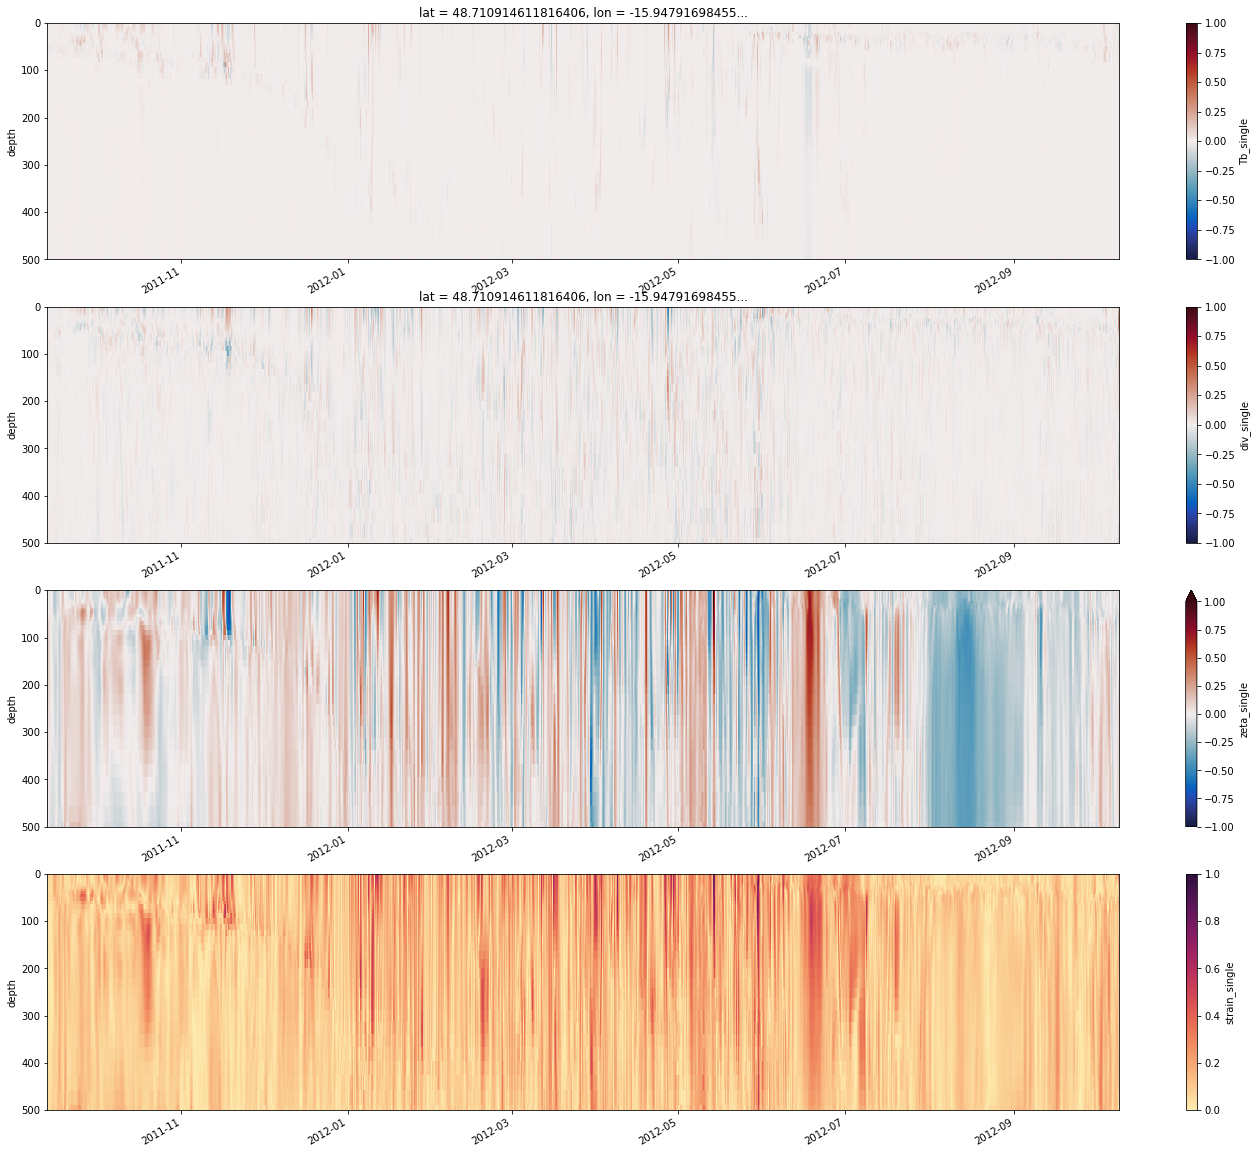

In [29]:
fig = plt.figure(figsize=(24,20))

ax = plt.subplot(411)
ds_vs.Tb_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(500, 0)
plt.xlabel('')

ax = plt.subplot(412)
ds_vs.div_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(500, 0)
plt.xlabel('')

ax = plt.subplot(413)
ds_vs.zeta_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap=cm.balance, yincrease=False)
ax.set_ylim(500, 0)
ax.set_title('')
plt.xlabel('')

ax = plt.subplot(414)
ds_vs.strain_single.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1,cmap=cm.matter, yincrease=False)
ax.set_ylim(500, 0)
ax.set_title('')
plt.xlabel('')

# Tb

In [12]:
ndepth = [0, 21, 28, 39]
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.Tb_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.526444.datarmor0/ipykernel_41430/62456769.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/62456769.py:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/62456769.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either s

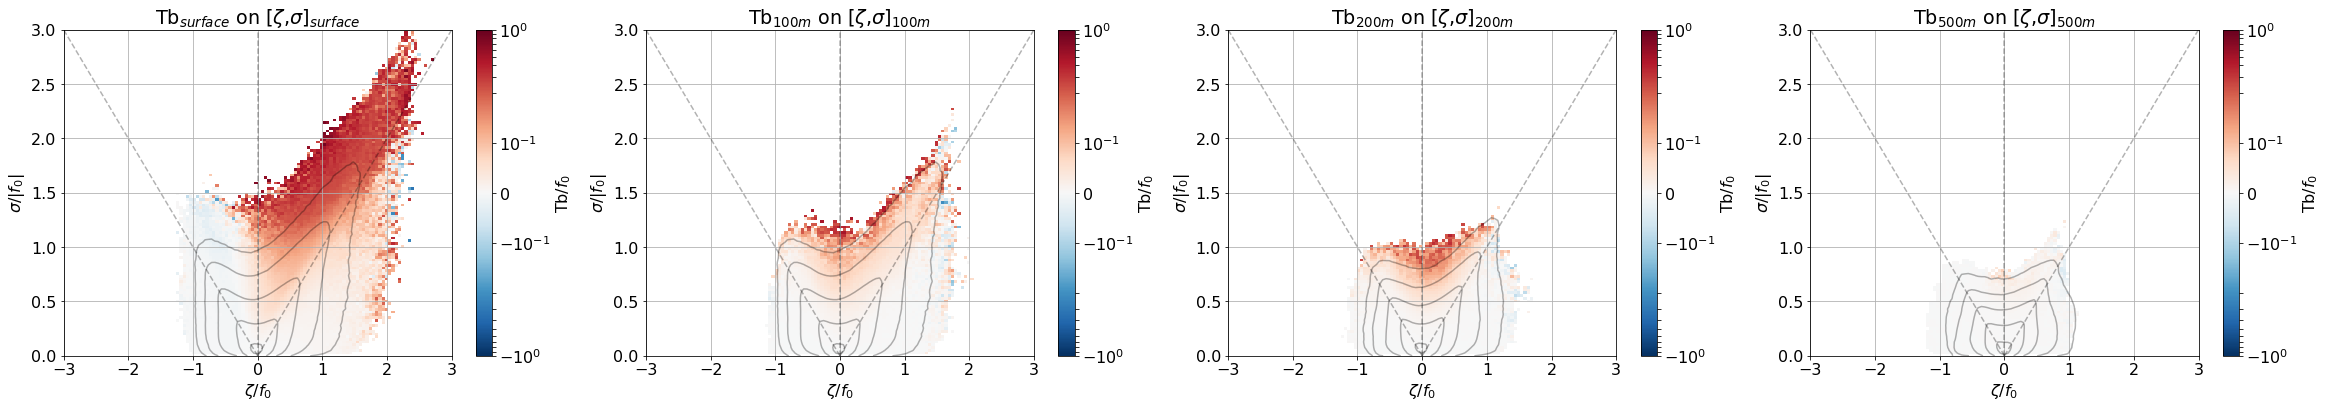

In [23]:
# Tb
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).mean(dim='time').T)*filter01


fig, ax = plt.subplots(figsize=(40,6))


ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb/$f_0$')
ax.set_title('Tb$_{surface}$ on [$\zeta$,$\sigma$]$_{surface}$')

ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb/$f_0$')
ax.set_title('Tb$_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')

ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb/$f_0$')
ax.set_title('Tb$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')

ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=3), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('Tb/$f_0$')
ax.set_title('Tb$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_Tb.png')

/dev/shm/pbs.526444.datarmor0/ipykernel_41430/2366426588.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/2366426588.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/2366426588.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

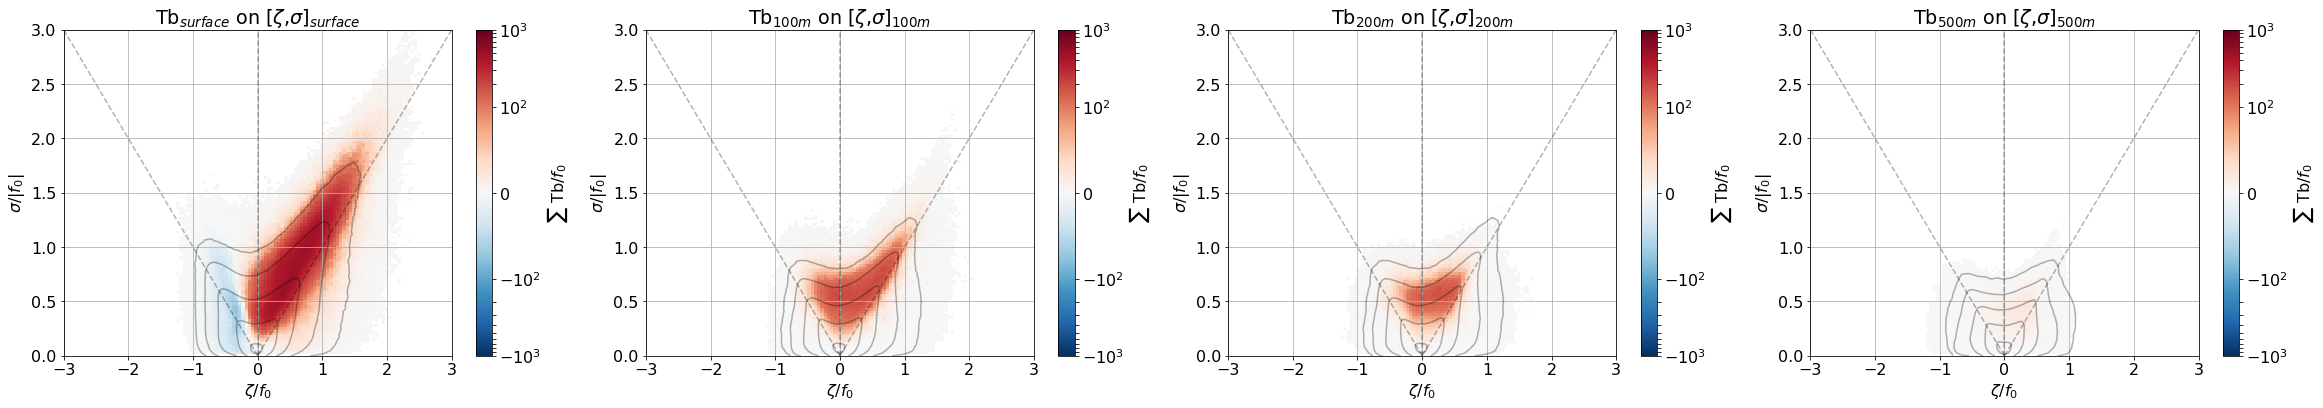

In [24]:
# Tb
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).sum(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(40,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum$ Tb/$f_0$')
ax.set_title('Tb$_{surface}$ on [$\zeta$,$\sigma$]$_{surface}$')

ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum$ Tb/$f_0$')
ax.set_title('Tb$_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')

ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum$ Tb/$f_0$')
ax.set_title('Tb$_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')

ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=3), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum$ Tb/$f_0$')
ax.set_title('Tb$_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_cum_Tb.png')

# DIV

In [25]:
ndepth = [0, 21, 28, 39]
vor_bin = np.linspace(-3, 3, 120)
sr_bin = np.linspace(0, 3, 120)

N = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              dim=['lat', 'lon'], 
              block_size=None
             )

E = histogram(
              ds_vs.zeta_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              ds_vs.strain_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(), 
              bins=[vor_bin, sr_bin], 
              weights= ds_vs.div_single.isel(depth=ndepth,lat=slice(1,-1),lon=slice(1,-1)).load(),
              dim=['lat', 'lon'], 
              block_size=None
             )

binbox01 =  (vor_bin[1]-vor_bin[0])*(sr_bin[1]-sr_bin[0])
girbNums01 = (len(ds_vs.zeta_single.lat)-2)*(len(ds_vs.zeta_single.lon)-2)

/dev/shm/pbs.526444.datarmor0/ipykernel_41430/607174231.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/607174231.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/607174231.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either 

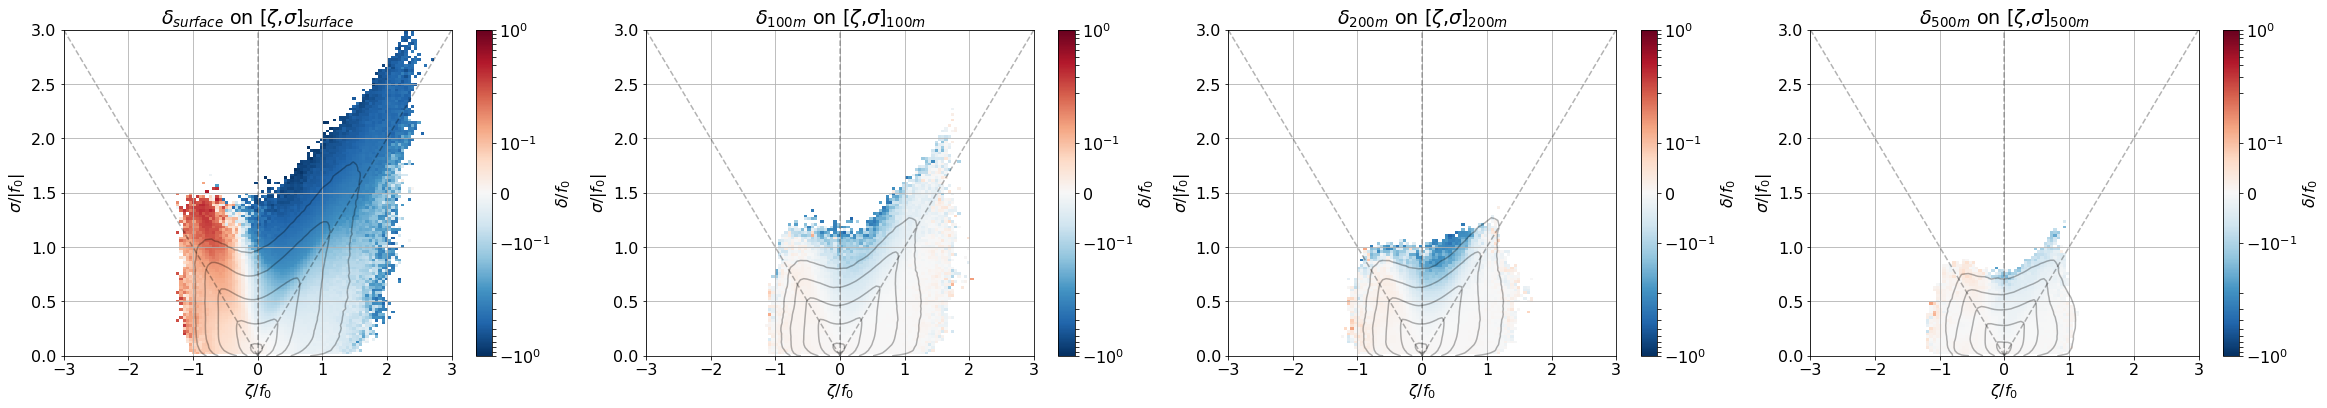

In [27]:
# DIV
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).mean(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(40,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\delta/f_0$')
ax.set_title('$\delta_{surface}$ on [$\zeta$,$\sigma$]$_{surface}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\delta/f_0$')
ax.set_title('$\delta_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\delta/f_0$')
ax.set_title('$\delta_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=3), 
             vmax=1e0,vmin=-1e0,norm=cols.SymLogNorm(2e-1), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\delta/f_0$')
ax.set_title('$\delta_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_DIV.png')

/dev/shm/pbs.526444.datarmor0/ipykernel_41430/1953422610.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/1953422610.py:8: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0),
/dev/shm/pbs.526444.datarmor0/ipykernel_41430/1953422610.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

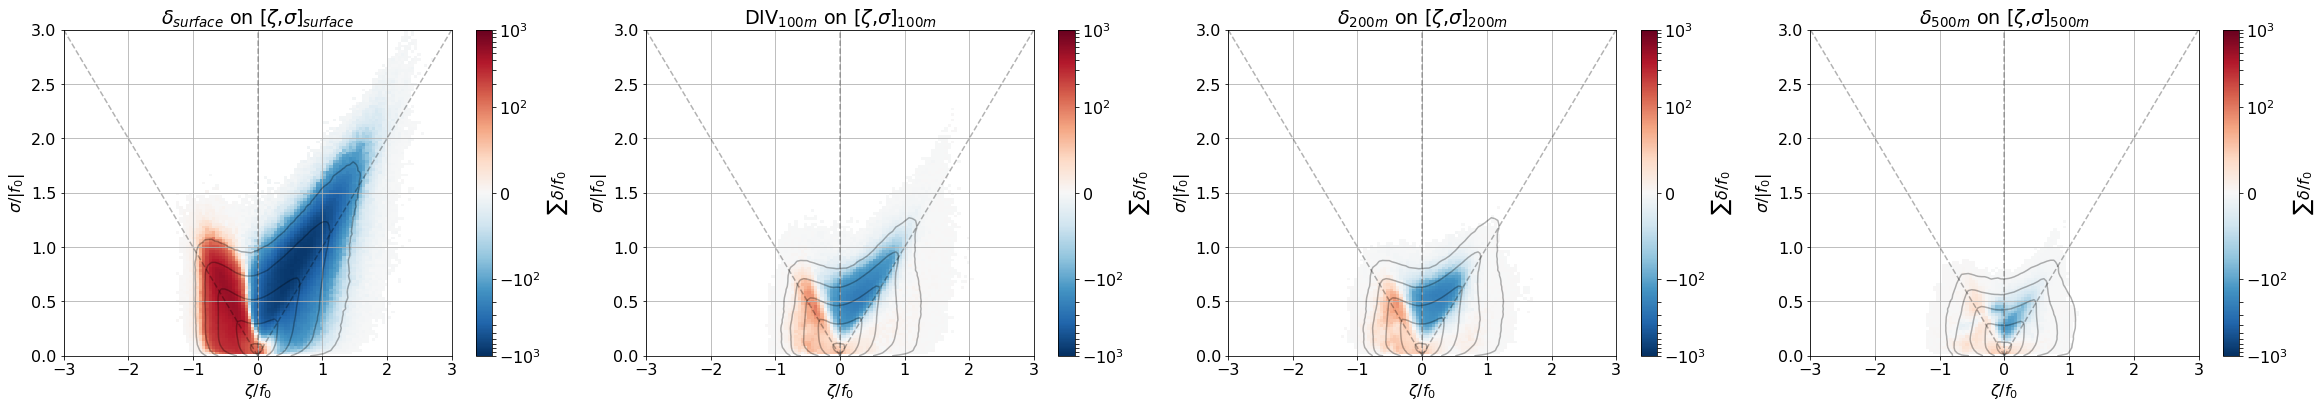

In [29]:
# cum DIV
filter01 = xr.where((1/(binbox01*girbNums01)*N.mean(dim='time').T)>=1e-5, 1, np.NaN)
W = ((E/N).sum(dim='time').T)*filter01

fig, ax = plt.subplots(figsize=(40,6))

ax = plt.subplot(141)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=0), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=0).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum \delta/f_0$')
ax.set_title('$\delta_{surface}$ on [$\zeta$,$\sigma$]$_{surface}$')


ax = plt.subplot(142)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=1), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum \delta/f_0$')
ax.set_title('DIV$_{100m}$ on [$\zeta$,$\sigma$]$_{100m}$')


ax = plt.subplot(143)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=2), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=1).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum \delta/f_0$')
ax.set_title('$\delta_{200m}$ on [$\zeta$,$\sigma$]$_{200m}$')


ax = plt.subplot(144)
im00 = ax.pcolormesh(N.zeta_single_bin, N.strain_single_bin, W.isel(depth=3), 
             vmax=1e3,vmin=-1e3,norm=cols.SymLogNorm(1e2), cmap='RdBu_r', rasterized=True)
ax.grid()
ax.set_xlim([-3,3])
ax.set_ylim([0,3])
ax.plot(np.linspace(0,-3,29),np.linspace(0,3,29),'k--',alpha=.3)
ax.plot(np.linspace(0,3),np.linspace(0,3),'k--',alpha=.3)
ax.plot(np.linspace(0,0),np.linspace(0,3),'k--',alpha=.3)
plt.contour(np.linspace(-3, 3, 119), np.linspace(0, 3, 119), ((1**2)/(binbox01*2000**2)*N.isel(depth=2).mean(dim='time').T), 
            levels=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1], colors='k', alpha=.3)
ax.set_xlabel('$\zeta/f_0$')
ax.set_ylabel('$\sigma/|f_0|$')
h00 = fig.colorbar(im00, ax=ax)
h00.set_label('$\sum \delta/f_0$')
ax.set_title('$\delta_{500m}$ on [$\zeta$,$\sigma$]$_{500m}$')

plt.savefig('/home1/datahome/xyu/OSMOSIS_moorings/KE_LLC4320/Diagnostics/Figures/VS_JPDF/VS_jpdf_cum_DIV.png')

In [32]:
cluster.close()